In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt

import nltk
from wordcloud import WordCloud
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from ekphrasis.classes.segmenter import Segmenter

df=pd.read_csv('tweets.csv')
df.head(10)

[nltk_data] Downloading package wordnet to /home/dhaya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dhaya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,author_id,like_count,link,quote_count,reply_count,retweet_count,tweet_body,tweet_id,tweeted_at
0,1,16973333,0,https://twitter.com/16973333/status/1373631143...,0,0,1,Opinion: It’s 15 years since Twitter launched ...,1373631143325622272,2021-03-21T13:42:40.000Z
1,2,1652541,17,https://twitter.com/1652541/status/13736305196...,1,0,1,Mideast stocks: Major Gulf markets ease in ear...,1373630519670345741,2021-03-21T13:40:11.000Z
2,3,807095,72,https://twitter.com/807095/status/137363048084...,11,16,40,New York has reported its first confirmed case...,1373630480843743234,2021-03-21T13:40:02.000Z
3,4,1652541,48,https://twitter.com/1652541/status/13736304730...,1,0,15,ICYMI: 'Beyond Walls' artist Saype spray-paint...,1373630473008726016,2021-03-21T13:40:00.000Z
4,5,25049056,4,https://twitter.com/25049056/status/1373629861...,0,0,2,Saudi Aramco reports $49bn profit slump in 202...,1373629861009395716,2021-03-21T13:37:34.000Z
5,6,788524,4,https://twitter.com/788524/status/137362938255...,0,0,1,Outdoor shows and decoy audiences herald retur...,1373629382556798978,2021-03-21T13:35:40.000Z
6,7,16973333,10,https://twitter.com/16973333/status/1373629381...,0,1,6,Women hold the key to tackling climate change ...,1373629381722128386,2021-03-21T13:35:40.000Z
7,8,1652541,57,https://twitter.com/1652541/status/13736292600...,1,5,20,Germany considers compulsory quarantines for p...,1373629260087369731,2021-03-21T13:35:11.000Z
8,9,5988062,28,https://twitter.com/5988062/status/13736289734...,1,6,11,Senior Chinese officials have thrust themselve...,1373628973410885635,2021-03-21T13:34:02.000Z
9,10,759251,269,https://twitter.com/759251/status/137362823377...,13,20,67,"A ""Star Wars"" fan in Russia built a 45-foot-lo...",1373628233778888711,2021-03-21T13:31:06.000Z


In [2]:
import numpy as np
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

np.random.seed(400)

In [3]:
df_clean_train=pd.DataFrame()
df_clean_train['content'] = df.tweet_body.str.lower()
df_clean_train['tweet_id'] = df.tweet_id

df_clean_test=pd.DataFrame()
df_clean_test['content'] = df_clean_train.content
df_clean_test['tweet_id'] = df.tweet_id

df_clean_train.drop(df_clean_train.index[26000:26203],0,inplace=True)
df_clean_test.drop(df_clean_test.index[:26000],0,inplace=True)

df_clean_train.head()

,content,tweet_id
0,opinion: it’s 15 years since twitter launched ...,1373631143325622272
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741
2,new york has reported its first confirmed case...,1373630480843743234
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016
4,saudi aramco reports $49bn profit slump in 202...,1373629861009395716


In [4]:
print("train: {} and test: {}".format(len(df_clean_train.index),len(df_clean_test.index)))

train: 26000 and test: 203


In [5]:
df_clean_train.content = df_clean_train.content.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
df_clean_train.content.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))

df_clean_test.content = df_clean_test.content.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
df_clean_test.content.apply(lambda x: re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))


df_clean_train.head()

,content,tweet_id
0,opinion: it’s 15 years since twitter launched ...,1373631143325622272
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741
2,new york has reported its first confirmed case...,1373630480843743234
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016
4,saudi aramco reports $49bn profit slump in 2020,1373629861009395716


In [6]:
df_clean_train.content = df_clean_train.content.apply(lambda x: re.sub(r'@[a-z0-9]*', '', x))

df_clean_test.content = df_clean_test.content.apply(lambda x: re.sub(r'@[a-z0-9]*', '', x))

df_clean_train.head(10)

,content,tweet_id
0,opinion: it’s 15 years since twitter launched ...,1373631143325622272
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741
2,new york has reported its first confirmed case...,1373630480843743234
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016
4,saudi aramco reports $49bn profit slump in 2020,1373629861009395716
5,outdoor shows and decoy audiences herald retur...,1373629382556798978
6,women hold the key to tackling climate change ...,1373629381722128386
7,germany considers compulsory quarantines for p...,1373629260087369731
8,senior chinese officials have thrust themselve...,1373628973410885635
9,"a ""star wars"" fan in russia built a 45-foot-lo...",1373628233778888711


In [7]:
df_clean_train.content = df_clean_train.content.apply(lambda x: re.sub(r"[^a-z0-9\s\(\-:\)\\\/\];='#]", '', x))

df_clean_test.content = df_clean_test.content.apply(lambda x: re.sub(r"[^a-z0-9\s\(\-:\)\\\/\];='#]", '', x))

df_clean_train.head(10)

,content,tweet_id
0,opinion: its 15 years since twitter launched ...,1373631143325622272
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741
2,new york has reported its first confirmed case...,1373630480843743234
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016
4,saudi aramco reports 49bn profit slump in 2020,1373629861009395716
5,outdoor shows and decoy audiences herald retur...,1373629382556798978
6,women hold the key to tackling climate change ...,1373629381722128386
7,germany considers compulsory quarantines for p...,1373629260087369731
8,senior chinese officials have thrust themselve...,1373628973410885635
9,a star wars fan in russia built a 45-foot-long...,1373628233778888711


In [8]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

df_clean_train['tokens'] = df_clean_train['content'].apply(tknzr.tokenize)


df_clean_test['tokens'] = df_clean_test['content'].apply(tknzr.tokenize)

df_clean_train.head(10)

,content,tweet_id,tokens
0,opinion: its 15 years since twitter launched ...,1373631143325622272,"[opinion, :, its, 15, years, since, twitter, l..."
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741,"[mideast, stocks, :, major, gulf, markets, eas..."
2,new york has reported its first confirmed case...,1373630480843743234,"[new, york, has, reported, its, first, confirm..."
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016,"[icymi, :, ', beyond, walls, ', artist, saype,..."
4,saudi aramco reports 49bn profit slump in 2020,1373629861009395716,"[saudi, aramco, reports, 49bn, profit, slump, ..."
5,outdoor shows and decoy audiences herald retur...,1373629382556798978,"[outdoor, shows, and, decoy, audiences, herald..."
6,women hold the key to tackling climate change ...,1373629381722128386,"[women, hold, the, key, to, tackling, climate,..."
7,germany considers compulsory quarantines for p...,1373629260087369731,"[germany, considers, compulsory, quarantines, ..."
8,senior chinese officials have thrust themselve...,1373628973410885635,"[senior, chinese, officials, have, thrust, the..."
9,a star wars fan in russia built a 45-foot-long...,1373628233778888711,"[a, star, wars, fan, in, russia, built, a, 45,..."


In [9]:
PUNCUATION_LIST = list(string.punctuation)
def remove_punctuation(word_list):
    """Remove punctuation tokens from a list of tokens"""
    return [w for w in word_list if w not in PUNCUATION_LIST]

df_clean_train['tokens'] = df_clean_train['tokens'].apply(remove_punctuation)


df_clean_test['tokens'] = df_clean_test['tokens'].apply(remove_punctuation)

df_clean_train.head(10)

,content,tweet_id,tokens
0,opinion: its 15 years since twitter launched ...,1373631143325622272,"[opinion, its, 15, years, since, twitter, laun..."
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741,"[mideast, stocks, major, gulf, markets, ease, ..."
2,new york has reported its first confirmed case...,1373630480843743234,"[new, york, has, reported, its, first, confirm..."
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016,"[icymi, beyond, walls, artist, saype, spray-pa..."
4,saudi aramco reports 49bn profit slump in 2020,1373629861009395716,"[saudi, aramco, reports, 49bn, profit, slump, ..."
5,outdoor shows and decoy audiences herald retur...,1373629382556798978,"[outdoor, shows, and, decoy, audiences, herald..."
6,women hold the key to tackling climate change ...,1373629381722128386,"[women, hold, the, key, to, tackling, climate,..."
7,germany considers compulsory quarantines for p...,1373629260087369731,"[germany, considers, compulsory, quarantines, ..."
8,senior chinese officials have thrust themselve...,1373628973410885635,"[senior, chinese, officials, have, thrust, the..."
9,a star wars fan in russia built a 45-foot-long...,1373628233778888711,"[a, star, wars, fan, in, russia, built, a, 45,..."


In [10]:
def hashtag_extraction(word_list):
    return [w for w in word_list if w[0]=='#']



In [11]:
df_clean_train['hashtags']=df_clean_train['tokens'].apply(hashtag_extraction)

df_clean_test['hashtags']=df_clean_test['tokens'].apply(hashtag_extraction)

df_clean_train.head(20)

,content,tweet_id,tokens,hashtags
0,opinion: its 15 years since twitter launched ...,1373631143325622272,"[opinion, its, 15, years, since, twitter, laun...",[]
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741,"[mideast, stocks, major, gulf, markets, ease, ...",[]
2,new york has reported its first confirmed case...,1373630480843743234,"[new, york, has, reported, its, first, confirm...",[]
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016,"[icymi, beyond, walls, artist, saype, spray-pa...",[]
4,saudi aramco reports 49bn profit slump in 2020,1373629861009395716,"[saudi, aramco, reports, 49bn, profit, slump, ...",[]
5,outdoor shows and decoy audiences herald retur...,1373629382556798978,"[outdoor, shows, and, decoy, audiences, herald...",[]
6,women hold the key to tackling climate change ...,1373629381722128386,"[women, hold, the, key, to, tackling, climate,...",[]
7,germany considers compulsory quarantines for p...,1373629260087369731,"[germany, considers, compulsory, quarantines, ...",[]
8,senior chinese officials have thrust themselve...,1373628973410885635,"[senior, chinese, officials, have, thrust, the...",[]
9,a star wars fan in russia built a 45-foot-long...,1373628233778888711,"[a, star, wars, fan, in, russia, built, a, 45,...",[]


In [12]:
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
def lemmatize_text(text):
 return [(lemmatizer.lemmatize(w)) for w in \
                                     w_tokenizer.tokenize((text))]

In [13]:
stop_words = set(stopwords.words('english'))
df_clean_train['tokens'] = df_clean_train['tokens'].apply(lambda x: [item for item in x if item not in stop_words])

df_clean_test['tokens'] = df_clean_test['tokens'].apply(lambda x: [item for item in x if item not in stop_words])

df_clean_train.head(20)

,content,tweet_id,tokens,hashtags
0,opinion: its 15 years since twitter launched ...,1373631143325622272,"[opinion, 15, years, since, twitter, launched,...",[]
1,mideast stocks: major gulf markets ease in ear...,1373630519670345741,"[mideast, stocks, major, gulf, markets, ease, ...",[]
2,new york has reported its first confirmed case...,1373630480843743234,"[new, york, reported, first, confirmed, case, ...",[]
3,icymi: 'beyond walls' artist saype spray-paint...,1373630473008726016,"[icymi, beyond, walls, artist, saype, spray-pa...",[]
4,saudi aramco reports 49bn profit slump in 2020,1373629861009395716,"[saudi, aramco, reports, 49bn, profit, slump, ...",[]
5,outdoor shows and decoy audiences herald retur...,1373629382556798978,"[outdoor, shows, decoy, audiences, herald, ret...",[]
6,women hold the key to tackling climate change ...,1373629381722128386,"[women, hold, key, tackling, climate, change, ...",[]
7,germany considers compulsory quarantines for p...,1373629260087369731,"[germany, considers, compulsory, quarantines, ...",[]
8,senior chinese officials have thrust themselve...,1373628973410885635,"[senior, chinese, officials, thrust, warring, ...",[]
9,a star wars fan in russia built a 45-foot-long...,1373628233778888711,"[star, wars, fan, russia, built, 45, foot-long...",[]


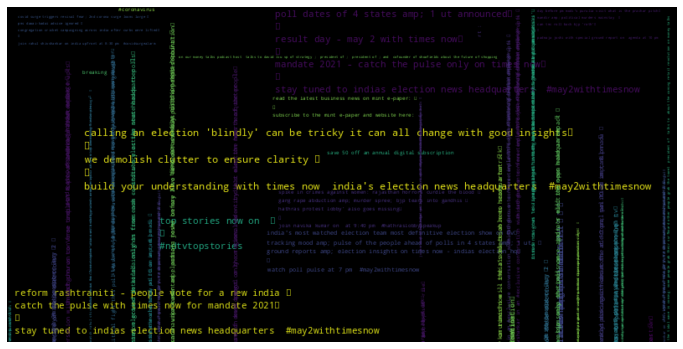

In [34]:
fdist = FreqDist(df_clean_train['content'])
#WordCloud
wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
plt.figure(figsize=(12,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [15]:
processed_docs_train = df_clean_train['tokens']

processed_docs_test = df_clean_test['tokens']

processed_docs_train[:10]


0    [opinion, 15, years, since, twitter, launched,...
1    [mideast, stocks, major, gulf, markets, ease, ...
2    [new, york, reported, first, confirmed, case, ...
3    [icymi, beyond, walls, artist, saype, spray-pa...
4    [saudi, aramco, reports, 49bn, profit, slump, ...
5    [outdoor, shows, decoy, audiences, herald, ret...
6    [women, hold, key, tackling, climate, change, ...
7    [germany, considers, compulsory, quarantines, ...
8    [senior, chinese, officials, thrust, warring, ...
9    [star, wars, fan, russia, built, 45, foot-long...
Name: tokens, dtype: object

In [16]:
dictionary = gensim.corpora.Dictionary(processed_docs_train)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 15
1 launched
2 opinion
3 ready
4 since
5 still
6 twitter
7 years
8 aramco
9 early
10 ease


In [17]:
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [18]:
bow_corpus_train = [dictionary.doc2bow(doc) for doc in processed_docs_train]

bow_corpus_test = [dictionary.doc2bow(doc) for doc in processed_docs_test]

In [19]:
'''
Preview BOW for our sample preprocessed document
'''
document_num = 20
bow_doc_x = bow_corpus_train[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 145 ("face") appears 1 time.
Word 154 ("13") appears 1 time.
Word 155 ("best") appears 1 time.


In [23]:
lda_model =  gensim.models.LdaMulticore(bow_corpus_train, 
                                   num_topics = 6, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 2)

In [24]:
def print_model(model):
    def print_topic(topic):
        topic_no, topic_repr = topic
        parts = topic_repr.split("+")
        words = [re.search('"(.*)"', part).group(1) for part in parts]
        return "{}: {}".format(topic_no, words)
    for topic in model.print_topics():
        print(print_topic(topic))
print_model(lda_model)

0: ['india', 'mumbai', 'us', 'first', 'says', 'indian', 'bank', 'new', 'england', 'year']
1: ['vaccine', 'covid', 'take', 'says', 'astrazeneca', 'uk', '19', 'new', 'read', 'ie']
2: ['minister', 'bjp', 'case', 'pm', 'details', 'bengal', 'chief', 'cm', 'police', 'west']
3: ['said', 'people', 'years', 'photo', 'new', 'us', 'ians', 'government', 'two', 'police']
4: ['covid', 'cases', '#covid19', 'new', '19', 'times', 'india', '2021', 'news', 'states']
5: ['election', 'amp', 'times', '#may2withtimesnow', 'polls', 'pm', 'news', "india's", 'rahul', 'ground']


In [35]:
topic_mapping = {
    0: "Finance",
    1: "Vaccine",
    2: "India",
    3: "Politics",
    4: "Covid 19",
    5: "Election"
}

In [36]:
document_num = 4
bow_doc_y = bow_corpus_test[document_num]

for i in range(len(bow_doc_y)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_y[i][0], 
                                                     dictionary[bow_doc_y[i][0]], 
                                                     bow_doc_y[i][1]))

Word 68 ("senior") appears 1 time.
Word 1391 ("team") appears 1 time.
Word 1603 ("domestic") appears 1 time.
Word 1977 ("teenager") appears 1 time.
Word 3314 ("ishan") appears 1 time.
Word 3315 ("kishan") appears 1 time.
Word 3489 ("#indvseng") appears 1 time.


In [37]:
for index, score in sorted(lda_model[bow_corpus_test[4]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.7642335891723633	 
Topic: 0.018*"india" + 0.013*"mumbai" + 0.012*"us" + 0.007*"first" + 0.007*"says" + 0.007*"indian" + 0.006*"bank" + 0.006*"new" + 0.006*"england" + 0.005*"year"

Score: 0.15203061699867249	 
Topic: 0.019*"vaccine" + 0.012*"covid" + 0.009*"take" + 0.007*"says" + 0.007*"astrazeneca" + 0.007*"uk" + 0.006*"19" + 0.006*"new" + 0.006*"read" + 0.006*"ie"

Score: 0.020989811047911644	 
Topic: 0.016*"said" + 0.008*"people" + 0.008*"years" + 0.007*"photo" + 0.007*"new" + 0.006*"us" + 0.006*"ians" + 0.006*"government" + 0.006*"two" + 0.006*"police"

Score: 0.02094951644539833	 
Topic: 0.016*"minister" + 0.016*"bjp" + 0.013*"case" + 0.012*"pm" + 0.012*"details" + 0.011*"bengal" + 0.010*"chief" + 0.010*"cm" + 0.008*"police" + 0.008*"west"

Score: 0.02093501202762127	 
Topic: 0.044*"election" + 0.027*"amp" + 0.023*"times" + 0.023*"#may2withtimesnow" + 0.016*"polls" + 0.016*"pm" + 0.014*"news" + 0.014*"india's" + 0.013*"rahul" + 0.013*"ground"

Score: 0.020861497148871422

In [38]:
print(lda_model.print_topic(index, 10))

0.027*"covid" + 0.025*"cases" + 0.019*"#covid19" + 0.016*"new" + 0.016*"19" + 0.015*"times" + 0.014*"india" + 0.013*"2021" + 0.011*"news" + 0.011*"states"


In [39]:
topic_probability = []
lda_vector = lda_model[bow_corpus_test]
for t in lda_vector:
      topic_probability.append(t)
results_test = pd.DataFrame(topic_probability,columns=["Finance", "Vaccine", "India", 
                                                       "Politics", "Covid 19", "Election"])
print(results_test)

              Finance           Vaccine             India          Politics  \
0    (0, 0.016803037)  (1, 0.016976032)  (2, 0.016698314)   (3, 0.91601706)   
1     (0, 0.02407757)   (1, 0.02389717)    (2, 0.5062649)   (3, 0.39770597)   
2    (0, 0.020836903)  (1, 0.020834498)    (2, 0.8955184)  (3, 0.020834673)   
3     (1, 0.15820135)   (3, 0.27927566)    (4, 0.5385374)              None   
4       (0, 0.764239)   (1, 0.15203317)   (2, 0.02094765)  (3, 0.020984592)   
..                ...               ...               ...               ...   
198    (2, 0.6805572)   (3, 0.20764685)   (4, 0.09165618)              None   
199   (0, 0.29523262)  (1, 0.011940609)  (2, 0.011948412)      (3, 0.65698)   
200   (0, 0.41974935)   (1, 0.02394049)  (2, 0.023820894)   (3, 0.48466873)   
201   (0, 0.54146886)  (1, 0.020917924)  (2, 0.020868955)    (3, 0.3749012)   
202   (0, 0.01858589)  (1, 0.018653996)    (2, 0.7747335)  (3, 0.018769326)   

             Covid 19          Election  
0    (4, 

In [40]:
df_clean_test.iloc[:,0:2]

,content,tweet_id
0,there are also events being organised where re...,1371132765513478149
1,the uae had in 2016 created the post of minist...,1371132764955635720
2,aiadmk releases manifesto for upcoming #tamiln...,1371132734500839427
3,#punjab chief secretary vini mahajan on sunday...,1371132599310057481
4,rt : #indvseng\r\n\r\nwhen ishan kishan burst ...,1371132221705261058
...,...,...
198,suvendu adhikari was part of nandigram agitati...,1371101307759644672
199,#newdelhi: the central government aims to sell...,1371101249949507587
200,the company will introduce a new 'jetpack tile...,1371100884571058178
201,rt : zimbabwe captain sean williams who remain...,1371100803482578944


In [41]:
final_topics = pd.DataFrame(columns=['topic'])
for t in lda_vector:
    topic_num=0
    curr_prob=0
    for prob in t:
        if(prob[1]>curr_prob):
            curr_prob=prob[1]
            topic_num=prob[0]
    final_topics.loc[len(final_topics.index)] = [topic_mapping[topic_num]]
final_topics.head()

,topic
0,Politics
1,India
2,India
3,Covid 19
4,Finance


In [42]:
df_clean_test.index = pd.RangeIndex(len(df_clean_test.index))
df_clean_test.head()

,content,tweet_id,tokens,hashtags
0,there are also events being organised where re...,1371132765513478149,"[also, events, organised, residents, invited, ...",[]
1,the uae had in 2016 created the post of minist...,1371132764955635720,"[uae, 2016, created, post, minister, state, ha...",[]
2,aiadmk releases manifesto for upcoming #tamiln...,1371132734500839427,"[aiadmk, releases, manifesto, upcoming, #tamil...","[#tamilnadu, #itvideo]"
3,#punjab chief secretary vini mahajan on sunday...,1371132599310057481,"[#punjab, chief, secretary, vini, mahajan, sun...","[#punjab, #covid19]"
4,rt : #indvseng\r\n\r\nwhen ishan kishan burst ...,1371132221705261058,"[rt, #indvseng, ishan, kishan, burst, domestic...",[#indvseng]


In [45]:
final_topics['content']=df_clean_test.iloc[:,0:1]
final_topics['tweet_id']=df_clean_test.iloc[:,1:2]
final_topics.head()

,topic,content,tweet_id
0,Politics,there are also events being organised where re...,1371132765513478149
1,India,the uae had in 2016 created the post of minist...,1371132764955635720
2,India,aiadmk releases manifesto for upcoming #tamiln...,1371132734500839427
3,Covid 19,#punjab chief secretary vini mahajan on sunday...,1371132599310057481
4,Finance,rt : #indvseng\r\n\r\nwhen ishan kishan burst ...,1371132221705261058


In [49]:
final_topics.to_csv('tweet_topics.csv', index=True, header=False)